# Introduction to Geospatial Data Science - Final Assignment (analysis script)

**Author: Márton Nagy**

**Note: This is only the analysis script. For the webscraping, please refer to the other uploaded notebook.**

# Data cleaning

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import os
import pickle

import geopandas as gpd
import osmnx as ox  
import matplotlib.pyplot as plt
from plotnine import *
color = ["#DB5461", "#080357", "#3B8EA5", "#3B8EA5", "#3B8EA5"]
import contextily as ctx
from shapely.geometry import Point, LineString, Polygon, MultiLineString, MultiPolygon, box

import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling

from libpysal.weights import DistanceBand, KNN
from esda.moran import Moran_Local
from esda.moran import Moran

import h3
import networkx as nx
from sklearn.cluster import SpectralClustering

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

import shap
from sklearn.inspection import permutation_importance
from mizani.formatters import percent_format

Reading the saved scraped data file.

In [2]:
df = pd.read_pickle('willhaben.pkl')

Dropping observations where I do not have price, size (as I will target square-meter price), or coordinates. I impute missing floor numbers with zeros.

In [3]:
df = df[
    df['price'].notna() &
    df['latitude'].notna() &
    df['longitude'].notna() &
    df['size'].notna()
]

df['floor'].fillna(0, inplace=True)

There seem to be some extreme values for some variables. I shall not target these simply because they are too irregular to fit into a general pattern.

In [4]:
df.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max,std
price,15246.0,592778.973304,1.0,119472.5,188000.0,225000.0,295000.0,399900.0,608975.0,1033464.0,1531200.0,3499000.0,15900000.0,755616.54843
is_active,15246.0,0.999147,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.029189
latitude,15246.0,48.210322,48.124403,48.136087,48.15167,48.170341,48.188269,48.209129,48.236454,48.253769,48.260929,48.28747,48.302486,0.0337
longitude,15246.0,16.368334,16.198876,16.215687,16.274781,16.295979,16.32866,16.36844,16.40059,16.443318,16.481064,16.51579,16.539982,0.05966
is_private,15246.0,0.017513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.131176
location_quality,15246.0,0.950999,0.0,0.0,0.67,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.172105
floor,15246.0,2.276466,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,6.0,24.55,45.0,3.97397
rooms,15246.0,2.600813,0.0,0.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,6.0,45.0,1.162397
size,15246.0,76.34737,13.0,30.0,35.0,40.0,49.0,65.0,88.0,121.0,152.75,263.0,1082.0,47.767009
published_date,15246,2025-03-12 01:07:23.507870976,2024-05-20 00:00:00,2025-02-19 00:11:09,2025-03-03 19:06:30,2025-03-05 16:21:30,2025-03-11 10:17:00,2025-03-12 20:39:00,2025-03-14 15:06:00,2025-03-17 03:21:00,2025-03-17 12:07:00,2025-03-17 15:30:33,2025-03-17 16:27:00,NaN


I drop per square-meter prices above 20,000 EUR.

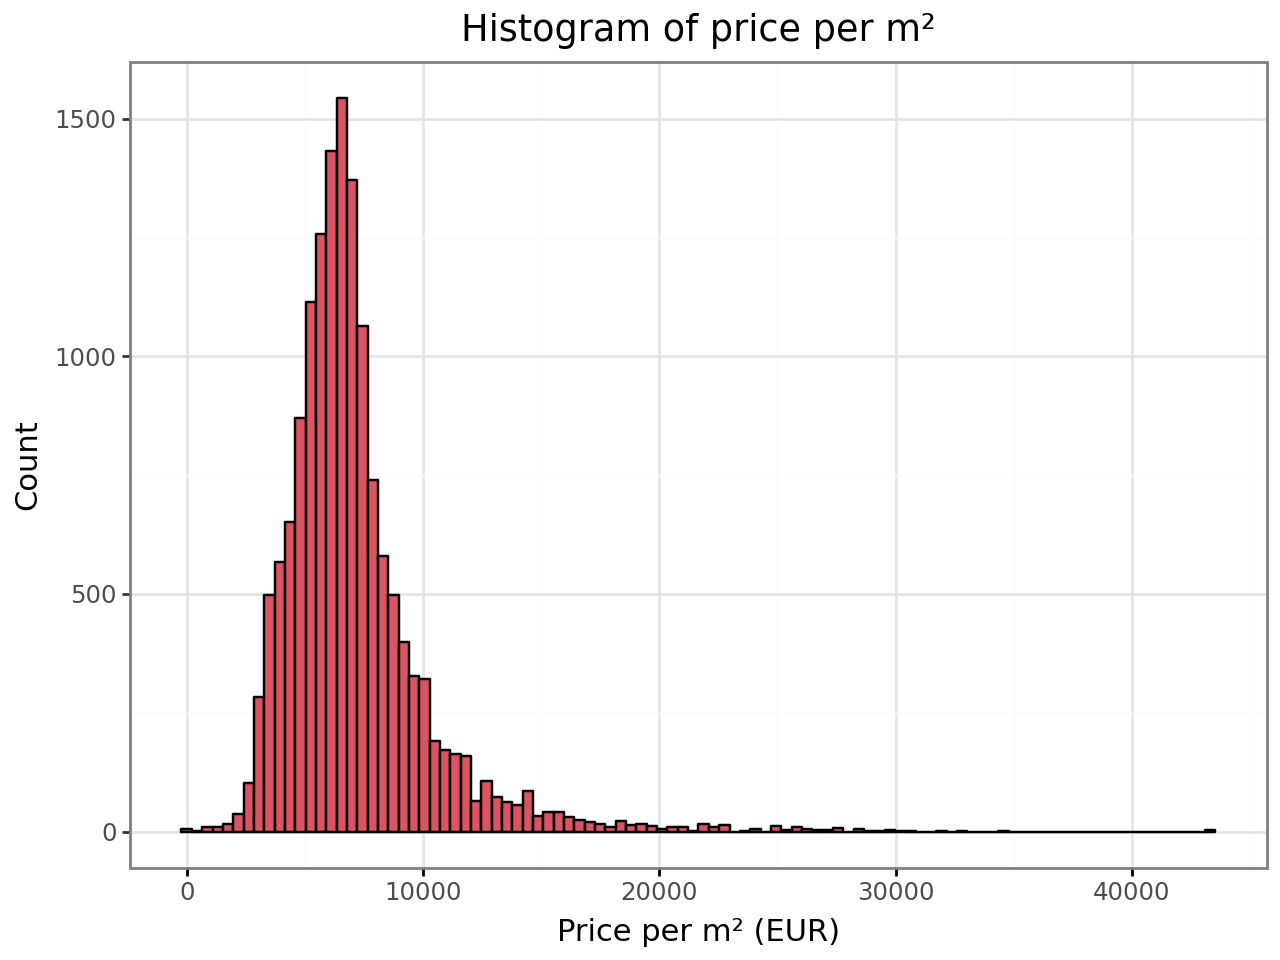

In [5]:
(
    ggplot(df, aes(x='m2_price'))
    + geom_histogram(bins=100, fill=color[0], color='black')
    + theme_bw()
    + labs(x='Price per m² (EUR)', y='Count', title='Histogram of price per m²')
)

In [6]:
df = df[df['m2_price'] < 20000]

There are some very large room counts. I looked into some of these manually, and these are mostly errors, so I replace it with the median value.

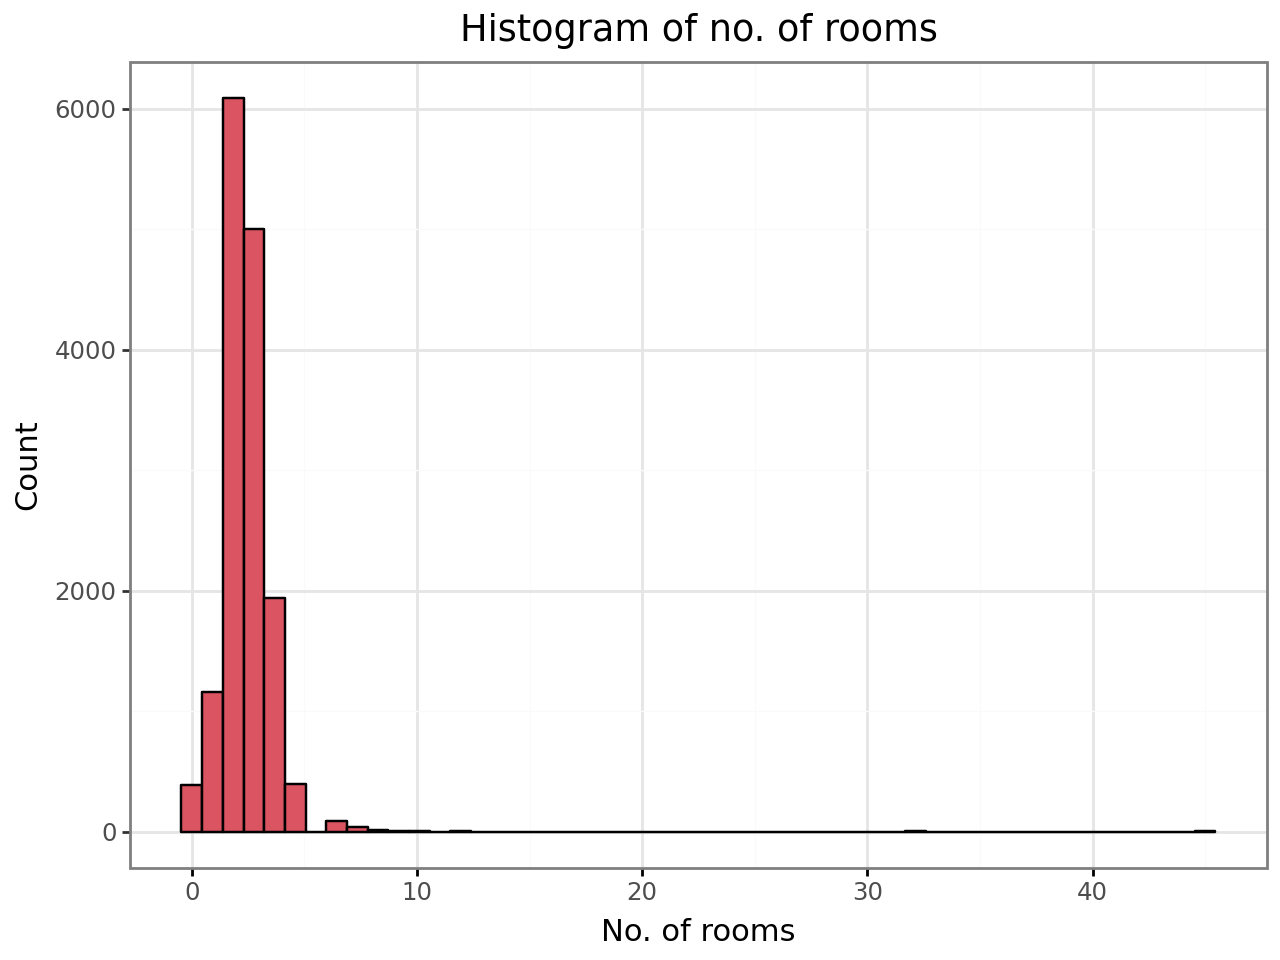

In [7]:
(
    ggplot(df, aes(x='rooms'))
    + geom_histogram(bins=50, fill=color[0], color='black')
    + theme_bw()
    + labs(x='No. of rooms', y='Count', title='Histogram of no. of rooms')
)

In [8]:
df['rooms'] = df['rooms'].apply(lambda x: np.median(df.rooms) if x > 10 else x)

There are some very big apartments, which again cannot fit into a general pattern. Thus, I drop observations with size above 300 square-meters.

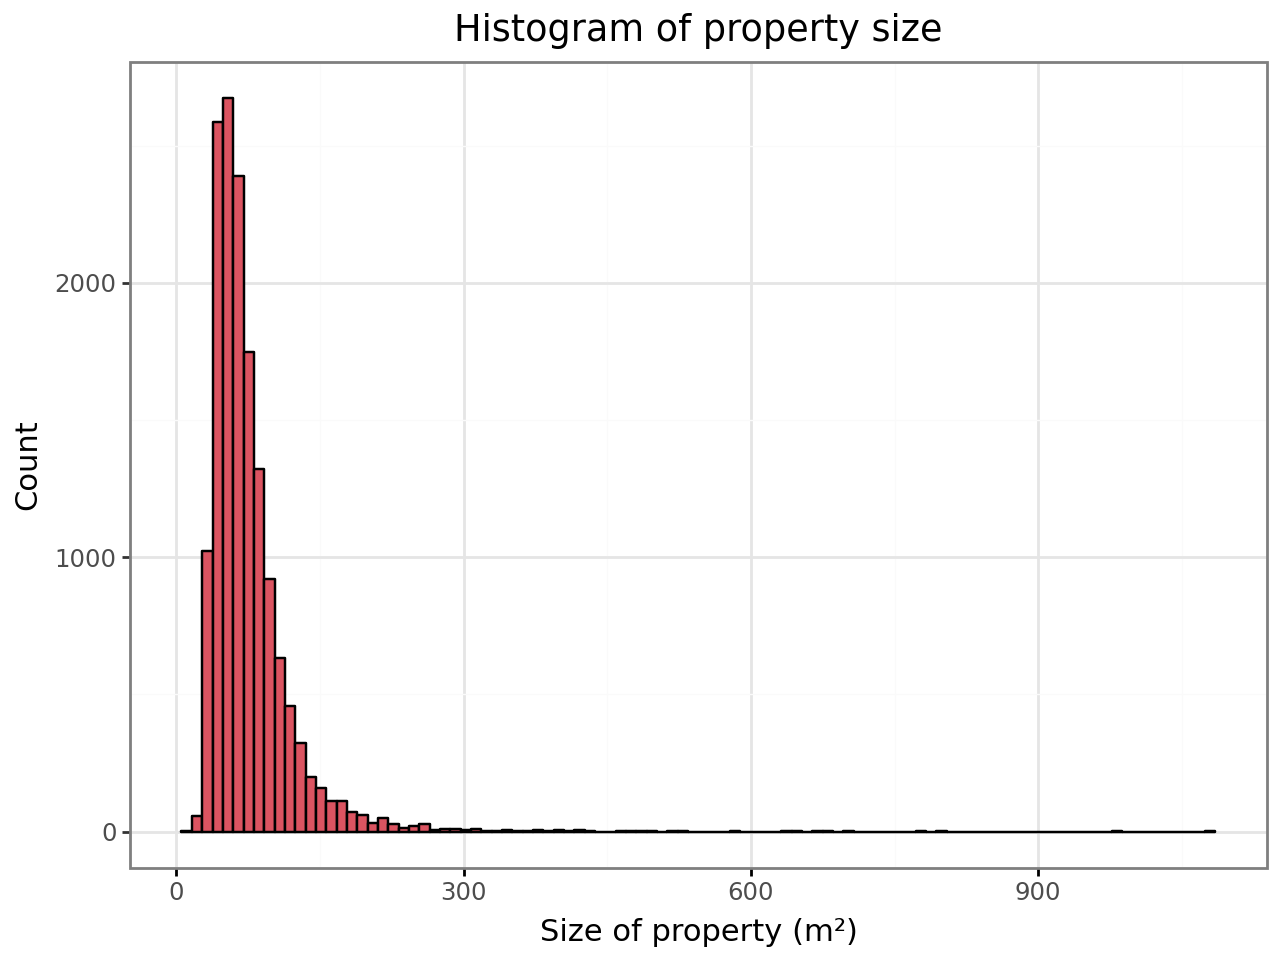

In [9]:
(
    ggplot(df, aes(x='size'))
    + geom_histogram(bins=100, fill=color[0], color='black')
    + theme_bw()
    + labs(x='Size of property (m²)', y='Count', title='Histogram of property size')
)

In [10]:
df = df[df['size'] < 300]

I convert my dataset to a GeoDataFrame.

In [11]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = 'EPSG:4326'

I define names of Viennese neighbourhoods and download boundaries of of Vienna and the individual neighbourhoods from OSM.

In [2]:
bezirk_list = ['Innere Stadt', 'Leopoldstadt', 'Landstraße', 'Wieden', 'Margareten', 'Mariahilf', 'Neubau',
               'Josefstadt', 'Alsergrund', 'Favoriten', 'Simmering', 'Meidling', 'Hietzing', 'Penzing',
               'Rudolfsheim-Fünfhaus', 'Ottakring', 'Hernals', 'Währing', 'Döbling', 'Brigittenau',
               'Floridsdorf', 'Donaustadt', 'Liesing']
bezirk_list = [i + ', Vienna, Austria' for i in bezirk_list]

In [3]:
bezirk_boundary = ox.geocode_to_gdf(bezirk_list)
vienna_boundary = ox.geocode_to_gdf('Vienna, Austria')

Let's take a look at the spatial distribution of the listings. We can see that there are some listings outside the actual boundaries of Vienna. I will drop these.

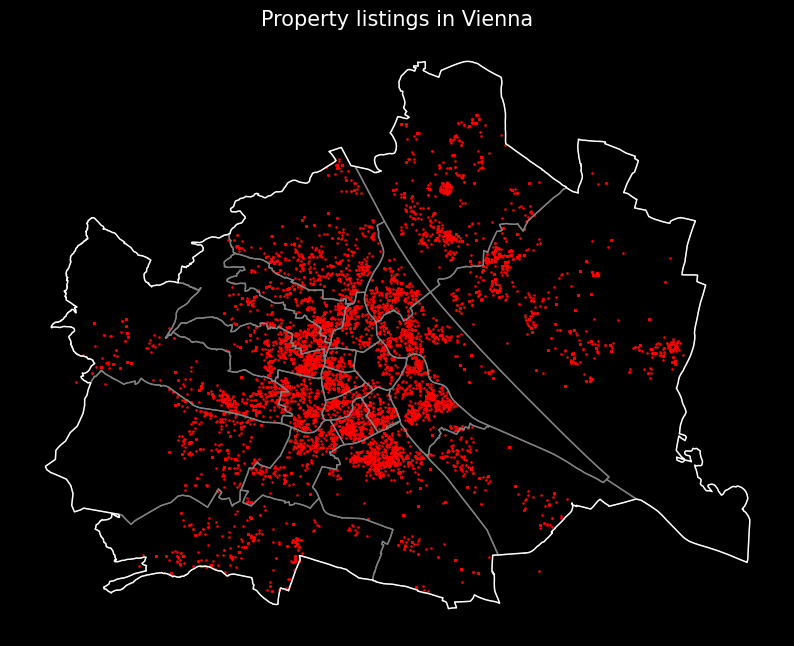

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='red', markersize=0.75)
bezirk_boundary.plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.plot(ax=ax, color='none', edgecolor='white')
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Property listings in Vienna', color='white', fontsize=15)
plt.show()

In [15]:
gdf = gdf[gdf.id.isin(gpd.overlay(gdf, vienna_boundary, how='intersection').id)]

Let's visualize now the price of the listings as well. We can see some nice visual patterns, most importantly that the inner city is very expensive, and prices tend to be lower the further away we are from the center. However, when we look further out, prices get higher again.

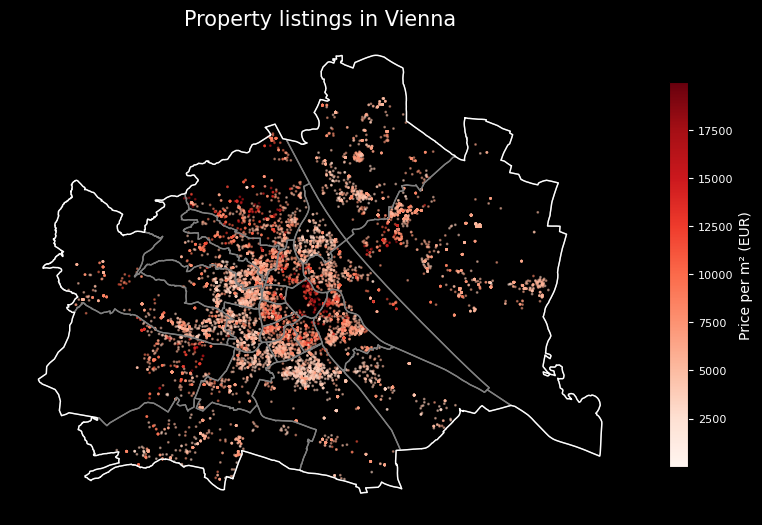

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='m2_price', cmap='Reds', markersize=1, alpha = 0.5, legend=True, legend_kwds={'shrink': 0.5})
cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Price per m² (EUR)', color='white', fontsize=10)
bezirk_boundary.plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.plot(ax=ax, color='none', edgecolor='white')
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Property listings in Vienna', color='white', fontsize=15)
plt.show()

# Data enrichment from OSM

Now let's try to enrich the dataset from OSM! My basic approach is to download many different tags which I assume can influence property prices. Then I will calculate the distance to the closest point of each category from every listing, and I will also count the number of points in each category within set radiuses of each listing.

In [4]:
crs_at = 31287
crs_wgs = 4326

In [5]:
tags = {
    'amenity' : [
        'bar', 'biergarten', 'cafe', 'fast_food', 'pub', 'restaurant',
        'college', 'kindergarten', 'school', 'university',
        'fuel', 'parking',
        'atm', 'bank',
        'clinic', 'dentist', 'doctors', 'hospital', 'pharmacy', 'veterinary',
        'cinema', 'theatre', 'place_of_worship'],
    'highway' :
        ['bus_stop'],
    'landuse' : [
        'commercial', 'industrial', 'residential', 'retail'],
    'leisure' : [
        'fitness_centre', 'garden', 'park', 'playground'],
    'public_transport' :
        ['station'],
    'shop' :
        ['convenience', 'supermarket'],
    'tourism' :
        ['attraction'],
    'waterway' : ['river']}

## Breakpoint 1: Run only if re-fetching data from OSM

In [76]:
osm_enrichment = {}
for key, value in tags.items():
    osm_enrichment[key] = ox.features_from_polygon(vienna_boundary.geometry.values[0], tags={key : value})

I save the downloaded OSM data to files.

In [ ]:
if not os.path.exists('osm_enrichment_pickles'):
    os.mkdir('osm_enrichment_pickles')
for key, value in osm_enrichment.items():
    value.to_pickle('osm_enrichment_pickles/' + key + '.pkl')

## Breakpoint 2: Run from here for saved OSM data

I load the saved files.

In [6]:
osm_enrichment = {}
for key, value in tags.items():
    osm_enrichment[key] = gpd.GeoDataFrame(pd.read_pickle('osm_enrichment_pickles/' + key + '.pkl'), geometry='geometry')

Some categories are very similar, so I group these together.

In [7]:
osm_enrichment['amenity'].amenity.replace({'biergarten' : 'bar', 'pub' : 'bar',
                                           'college' : 'university',
                                           'hospital' : 'clinic',}, inplace=True)

I define the new tags dictionary with the grouped categories.

In [8]:
new_tags = {
    'amenity' : [
        'bar', 'cafe', 'fast_food', 'restaurant',
        'kindergarten', 'school', 'university',
        'fuel', 'parking',
        'atm', 'bank',
        'clinic', 'dentist', 'doctors', 'pharmacy', 'veterinary',
        'cinema', 'theatre', 'place_of_worship'],
    'highway' :
        ['bus_stop'],
    'landuse' : [
        'commercial', 'industrial', 'residential', 'retail'],
    'leisure' : [
        'fitness_centre', 'garden', 'park', 'playground'],
    'public_transport' :
        ['station'],
    'shop' :
        ['convenience', 'supermarket'],
    'tourism' :
        ['attraction'],
    'waterway' : ['river']}

## Breakpoint 3: Run only if recalculating OSM enrichment

Now we can calculate the previously mentioned enrichment metrics. For the counts, I count the number of instances within a 100 meter and an 800 meter radius. I chose these as I believe 100 meter means basically immediate proximity, while 800 meters is roughly within a 10 minute walking distance. I do not calculate the counts for land-use and waterway categories, as these would be rather meaningless.

In [35]:
gdf = gdf.to_crs(crs_at)  

for key, values in new_tags.items():
    for val in values:
        filtered_osm = osm_enrichment[key][osm_enrichment[key][key] == val].to_crs(crs_at)
        
        if not filtered_osm.empty:
            nearest = gdf.sjoin_nearest(filtered_osm[['geometry']], how='left', distance_col=f'dist_{key}_{val}')
            nearest = nearest.loc[~nearest.index.duplicated(keep='first')]
            gdf[f'dist_{key}_{val}'] = nearest[f'dist_{key}_{val}']

            if key not in ['landuse', 'waterway']:
                for b in [100, 800]:
                    buffered = filtered_osm.copy()
                    buffered['geometry'] = buffered.buffer(b)
                    joined = gdf.sjoin(buffered, predicate='intersects')
                    gdf[f'count_{b}m_{key}_{val}'] = joined.groupby(joined.index).size()
        else:
            gdf[f'dist_{key}_{val}'] = float('nan')
            gdf[f'count_{key}_{val}'] = 0

gdf = gdf.to_crs(crs_wgs)

The counts are missing if there was no instance found of a certain type, so I replace these with zeros.

In [39]:
for c in [c for c in gdf.columns if c.startswith('count_')]:
    gdf[c] = gdf[c].fillna(0)

I save the OSM enriched file.

In [40]:
gdf.to_pickle('gdf_osm_enriched.pkl')

# Data enrichment from raster files
## Breakpoint 4: Run from here only if re-calculating raster aggregates

I load the OSM enriched file.

In [86]:
gdf = gpd.GeoDataFrame(pd.read_pickle('gdf_osm_enriched.pkl'), geometry='geometry')

Now we can enrich the data from GHS raster data (using the highest resolution, that is 3ss). I will calculate the number of people living within an 500 meter radius of each listing (for years 2025 and 2030), and the total built in volume (in cubic meters, thus this takes into account not only the surface area of buildings, but the height as well) within the same radius and for the same years. For this, I define a function to calculate the sum of the raster data within a radius.

In [9]:
def calc_raster_total(gdf, raster_file, b):
    gdf = gdf.copy()
    with rasterio.open(raster_file) as src:
        raster_data = src.read(1)
        raster_transform = src.transform
        raster_crs = src.crs
        
        gdf = gdf.to_crs(crs_at)
        gdf['geometry'] = gdf.buffer(b)
        gdf = gdf.to_crs(raster_crs)

        total = []

        for _, estate in gdf.iterrows():
            mask_array, mask_transform = mask(src, 
                                              [estate.geometry], 
                                              crop=True, 
                                              nodata=0)
            mask_array = mask_array[0]
            estate_total = np.nansum(mask_array)
            total.append(estate_total)

    return total

Note that the downloaded files are a single tile from the whole raster grid to save some disk space. However, these are still very large files, as I downloaded them in the highest possible resolution. So, I clip them to Vienna's boundary. Some cells for the clipping are commented out as they neccessitate having the initial large files in place.

In [ ]:
'''raster_files_whole = {
    'pop_2025' : 'ghs_raster_data/GHS_POP_E2025_GLOBE_R2023A_4326_3ss_V1_0_R5_C20/GHS_POP_E2025_GLOBE_R2023A_4326_3ss_V1_0_R5_C20.tif',
    'pop_2030' : 'ghs_raster_data/GHS_POP_E2030_GLOBE_R2023A_4326_3ss_V1_0_R5_C20/GHS_POP_E2030_GLOBE_R2023A_4326_3ss_V1_0_R5_C20.tif',
    'built_vol_2025' : 'ghs_raster_data/GHS_BUILT_V_E2025_GLOBE_R2023A_4326_3ss_V1_0_R5_C20/GHS_BUILT_V_E2025_GLOBE_R2023A_4326_3ss_V1_0_R5_C20.tif',
    'built_vol_2030' : 'ghs_raster_data/GHS_BUILT_V_E2030_GLOBE_R2023A_4326_3ss_V1_0_R5_C20/GHS_BUILT_V_E2030_GLOBE_R2023A_4326_3ss_V1_0_R5_C20.tif',
}'''

In [10]:
raster_files_clipped = {
    'pop_2025' : 'ghs_raster_data/pop_2025_clipped.tif',
    'pop_2030' : 'ghs_raster_data/pop_2030_clipped.tif',
    'built_vol_2025' : 'ghs_raster_data/built_vol_2025_clipped.tif',
    'built_vol_2030' : 'ghs_raster_data/built_vol_2030_clipped.tif'
}

In [ ]:
'''def clip_raster_to_vienna(raster_file, out_file):
    bbox = box(**vienna_boundary.bounds)
    box_gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs='EPSG:4326')
    box_gdf = box_gdf.to_crs(crs_at)
    box_gdf['geometry'] = box_gdf.buffer(500) # buffer to account for listings on the edge of Vienna
    box_gdf = box_gdf.to_crs(crs_wgs)

    with rasterio.open(raster_file) as src:
        out_image, out_transform = mask(src, box_gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    with rasterio.open(out_file, 'w', **out_meta) as dest:
        dest.write(out_image)'''

In [ ]:
'''for key, value in raster_files_whole.items():
    clip_raster_to_vienna(value, raster_files_clipped[key])'''

In [89]:
for key, value in raster_files_clipped.items():
    print(f'Processing {key}...')
    gdf[key] = calc_raster_total(gdf, value, 500)

Processing pop_2025...
Processing pop_2030...
Processing built_vol_2025...
Processing built_vol_2030...


In [13]:
gdf['built_vol_2025'] = gdf['built_vol_2025'].astype(int)
gdf['built_vol_2030'] = gdf['built_vol_2030'].astype(int)

Replacing zero values with ones to be able to calculate growth metrics for all observations.

In [14]:
gdf['pop_2025'] = gdf['pop_2025'].apply(lambda x: x if x > 0 else 1)
gdf['pop_2030'] = gdf['pop_2030'].apply(lambda x: x if x > 0 else 1)
gdf['built_vol_2025'] = gdf['built_vol_2025'].apply(lambda x: x if x > 0 else 1)
gdf['built_vol_2030'] = gdf['built_vol_2030'].apply(lambda x: x if x > 0 else 1)

I calculate some additional metrics: the distance to the city center, and population and built-in volume growth between 2025 and 2030.

In [15]:
gdf['dist_to_center'] = gdf.apply(lambda x : ox.distance.great_circle(x.latitude, x.longitude, 48.2081, 16.3713), axis=1)
gdf['pop_growth'] = gdf['pop_2030'] / gdf['pop_2025']
gdf['built_vol_growth'] = gdf['built_vol_2030'] / gdf['built_vol_2025']

I made some errors earlier in not dropping the lower end of the price distribution. Also, I find that properties with zero rooms are unrealistic, so I reassign these to having 1 room.

In [16]:
gdf = gdf[gdf['m2_price'] > np.quantile(gdf['m2_price'], 0.01)]
gdf['rooms'] = gdf['rooms'].apply(lambda x: 1 if x == 0 else x)

Lastly, let's compute the last spatial feature: neighbouring properties for sale within 500 meters.

In [ ]:
buffered = gdf.copy()
buffered = buffered.to_crs(crs_at)
buffered['geometry'] = buffered.buffer(500)
joined = gdf.to_crs(crs_at).sjoin(buffered, predicate='intersects')
gdf[f'count_{500}m_listings'] = joined.groupby(joined.index).size() - 1 # exclude self-join

I now save the fully enriched dataset.

In [28]:
gdf.to_pickle('gdf_full_enriched.pkl')

## Breakpoint 5: Run from here for fully enriched file

I load the enriched dataset.

In [9]:
gdf = gpd.GeoDataFrame(pd.read_pickle('gdf_full_enriched.pkl'), geometry='geometry')

Let's take a final look at our final dataset now.

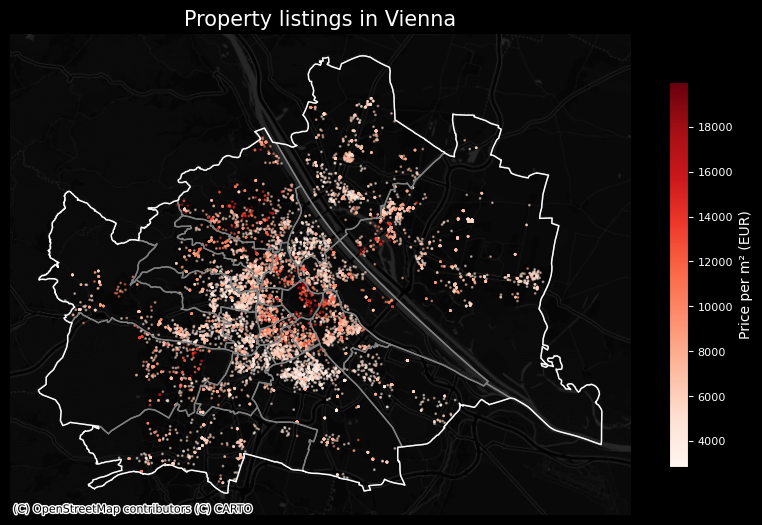

In [193]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.to_crs(crs_at).plot(ax=ax, column='m2_price', cmap='Reds', markersize=1, alpha = 0.5, legend=True, legend_kwds={'shrink': 0.5})
cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Price per m² (EUR)', color='white', fontsize=10)
bezirk_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='white')
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Property listings in Vienna', color='white', fontsize=15)
ctx.add_basemap(ax,  
                crs = crs_at, 
                source = ctx.providers.CartoDB.DarkMatterNoLabels,)

fig.savefig('vienna_listings.png', dpi=300)

plt.show()

We can also look at some other features, like the distance to the nearest industrial area, or population within 500 meter.

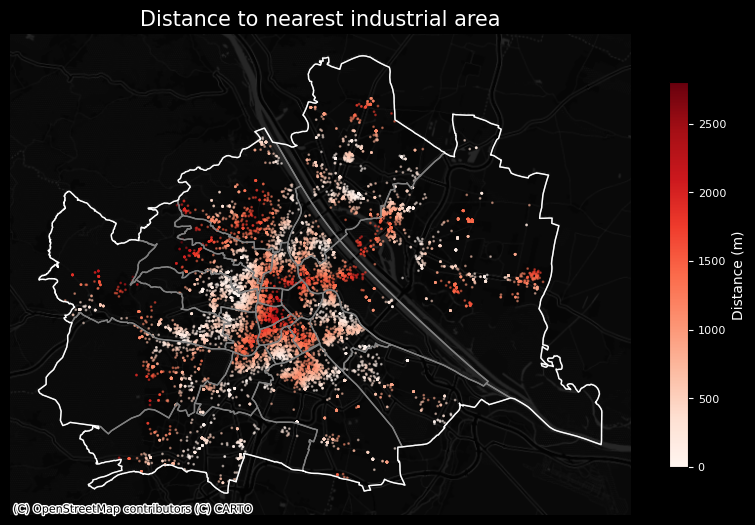

In [194]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.to_crs(crs_at).plot(ax=ax, column='dist_landuse_industrial', cmap='Reds', markersize=1, alpha = 0.5, legend=True, legend_kwds={'shrink': 0.5})
cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Distance (m)', color='white', fontsize=10)
bezirk_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='white')
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Distance to nearest industrial area', color='white', fontsize=15)
ctx.add_basemap(ax,  
                crs = crs_at, 
                source = ctx.providers.CartoDB.DarkMatterNoLabels,)

fig.savefig('dist_industrial.png', dpi=300)

plt.show()

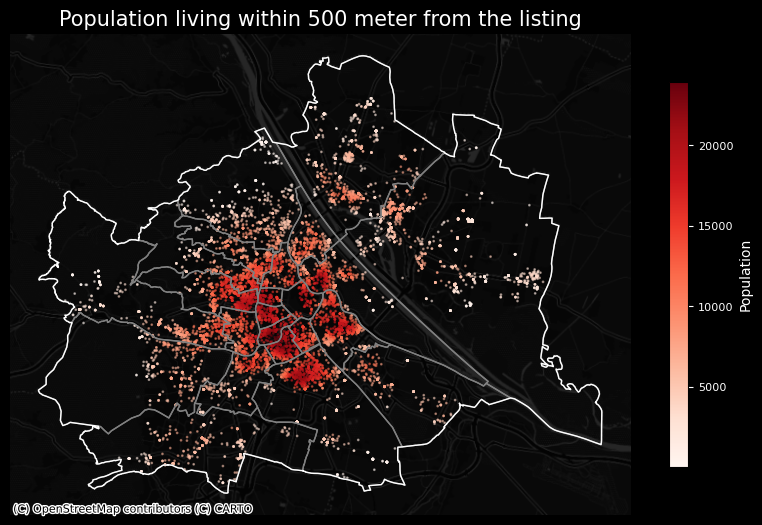

In [195]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.to_crs(crs_at).plot(ax=ax, column='pop_2025', cmap='Reds', markersize=1, alpha = 0.5, legend=True, legend_kwds={'shrink': 0.5})
cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Population', color='white', fontsize=10)
bezirk_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='white')
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Population living within 500 meter from the listing', color='white', fontsize=15)
ctx.add_basemap(ax,  
                crs = crs_at, 
                source = ctx.providers.CartoDB.DarkMatterNoLabels,)

fig.savefig('pop_2025.png', dpi=300)

plt.show()

Let's do some final data preparation before modeling: I calculate the neighbourhood of each listing, and clean up very rare advertisers and property types.

In [10]:
result = gpd.sjoin(bezirk_boundary.to_crs(crs_at), gdf.to_crs(crs_at), how='inner', predicate='contains')
bezirk_mapping = result.groupby(result.index_right)['name'].first()
gdf['bezirk'] = gdf.index.map(bezirk_mapping)
gdf['bezirk'] = gdf['bezirk'].astype('category')

In [11]:
advertiser_counts = gdf['advertiser_id'].value_counts()
gdf['advertiser_id_cleaned'] = gdf['advertiser_id'].map(lambda x: '99999999' if advertiser_counts[x] < 100 else x)
gdf['advertiser_id_cleaned'] = gdf['advertiser_id_cleaned'].astype('category')

In [12]:
gdf['property_type_cleaned'] = gdf['property_type'].map(lambda x: 'Other' if x in ['Garconniere', 'Sonstige', 'Rohdachboden', 'Genossenschaftswohnung'] else x)
gdf['property_type_cleaned'] = gdf['property_type_cleaned'].astype('category')

I drop columns not needed for modelling.

In [13]:
drop_cols = ['price', 'id', 'url', 'is_active', 'description', 'location', 'country', 'property_type',
             'state', 'address', 'district', 'postcode', 'advertiser','advertiser_id', 'published_date', 'size']
gdf.drop(drop_cols, axis=1, inplace=True)

# Breakpoint 6: Run from here only if retraining RF model

I decided to model the property prices using a spatial Random Forest. I opted for this instead of SEM or SLM models, as for the latter, it is very hard to make predictions for completely new observations, as the whole weight matrix changes with the addition of new observations. Thus, both cross-validation and predictions would have been very cumbersome to implement. In addition, as I have many possible features, I can leverage Random Forest to automatically select the most important features.

Note that I exclude latitude and longitude from my model, as later the predictions should be extrapolated in their coordinates, in which RF is really not good at. Moreover, I believe that most the coordinates information contents are captured by the previously defined spatial features.

In [41]:
cat_vars = ['bezirk', 'advertiser_id_cleaned', 'property_type_cleaned']
num_vars = [c for c in gdf.columns if c not in cat_vars + ['latitude', 'longitude', 'geometry', 'm2_price']]

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

rf_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', 'passthrough', num_vars),
        ('cat', OneHotEncoder(), cat_vars)
    ])),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_dist = {
    'rf__n_estimators': list(range(50, 300, 25)),
    'rf__max_depth': list(range(5, 40, 5)),
    'rf__min_samples_split': list(range(2, 10, 1)),
    'rf__min_samples_leaf': list(range(2, 5, 1)),
    'rf__max_features': list(range(10, 25, 1))
}

rf_cv = RandomizedSearchCV(
    rf_pipe, param_dist, n_iter=100, cv=k_fold, scoring='neg_mean_squared_error', 
    n_jobs=-1, verbose=0, refit=True, random_state=42
)

rf_cv.fit(gdf.drop(['geometry'], axis=1), gdf['m2_price'])

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['is_private',
                                                                                'location_quality',
                                                                                'floor',
                                                                                'rooms',
                                                                                'terrace_size',
                                                                                'garden_size',
                                                                                'balcony_size',
                                                                                'loggia_size',
                                                                                'roof_terrace_size',
                                                                                'winter_garden_size',
                                                                                'ad_age',
                                                                                'is_new_build',
                                                                                'is_renovated'...
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__max_depth': [5, 10, 15, 20, 25, 30,
                                                          35],
                                        'rf__max_features': [10, 11, 12, 13, 14,
                                                             15, 16, 17, 18, 19,
                                                             20, 21, 22, 23,
                                                             24],
                                        'rf__min_samples_leaf': [2, 3, 4],
                                        'rf__min_samples_split': [2, 3, 4, 5, 6,
                                                                  7, 8, 9],
                                        'rf__n_estimators': [50, 75, 100, 125,
                                                             150, 175, 200, 225,
                                                             250, 275]},
                   random_state=42, scoring='neg_mean_squared_error')

I save the trained model to disk.

In [42]:
with open("rf_cv.pkl", "wb") as f:
    pickle.dump(rf_cv, f)

# Breakpoint 7: Run from here for saved RF model

I open the saved model.

In [14]:
with open("rf_cv.pkl", "rb") as f:
    rf_cv = pickle.load(f)

I make in-sample predictions and calculate the residuals.

In [15]:
gdf['m2_price_pred'] = rf_cv.predict(gdf.drop(['geometry'], axis=1))
gdf['m2_price_resid'] = gdf['m2_price'] - gdf['m2_price_pred']

Now we can take a look at the CV RMSE and the full-sample RMSE. We can see that our model had an average error of roughly 1300 EUR during cross-validation. This value is the more informative, as it measures model performance on completely unseen data. The full sample RMSE is lower than this, roughly 800 EUR.

In [16]:
print(f'CV RMSE: {np.sqrt(-rf_cv.best_score_):.2f} ({np.sqrt(-rf_cv.best_score_) / gdf["m2_price"].mean():.2%} of sample mean)')
print(f'Full RMSE: {np.sqrt(mean_squared_error(gdf["m2_price"], gdf["m2_price_pred"])):.2f} ({np.sqrt(mean_squared_error(gdf["m2_price"], gdf["m2_price_pred"])) / gdf["m2_price"].mean():.2%} of sample mean)')

CV RMSE: 1330.23 (19.00% of sample mean)
Full RMSE: 791.84 (11.31% of sample mean)


We can also take a look at whether the model residuals are spatially correlated. We can see that Moran's I value is very close to zero, thus even though the result is statistically significant, we can say that most of the spatial dependencies have been incorporated into the model.

In [17]:
w = KNN.from_dataframe(gdf, k=10)
moran = Moran(gdf['m2_price_resid'], w)

print(f"Moran's I: {moran.I:.2f}, p-value: {moran.p_sim}")

Moran's I: -0.02, p-value: 0.001


To better understand what the Random Forest model is doing, we can plot the variable importances and we can even calculate some SHAP values.

In [18]:
cat_vars = ['bezirk', 'advertiser_id_cleaned', 'property_type_cleaned']
num_vars = [c for c in gdf.columns if c not in cat_vars + ['latitude', 'longitude', 'geometry', 'm2_price']]

In [158]:
perm_imp_res = permutation_importance(
    rf_cv.best_estimator_,
    gdf.drop(['geometry'], axis=1),
    gdf['m2_price'],
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

In [159]:
grouped_imp = (
    pd.DataFrame(perm_imp_res.importances_mean, gdf.drop(['geometry'], axis=1).columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [160]:
grouped_imp.to_pickle('grouped_imp.pkl')

In [19]:
grouped_imp = pd.read_pickle('grouped_imp.pkl')

From the variable importance plot, we can see that the most important features are related to the size of certain amenities, such as a terrace or a balcony. The most important geospatial features are the distance to the city center, distance to the nearest industrial area, and the distance to the nearest touristic attraction.

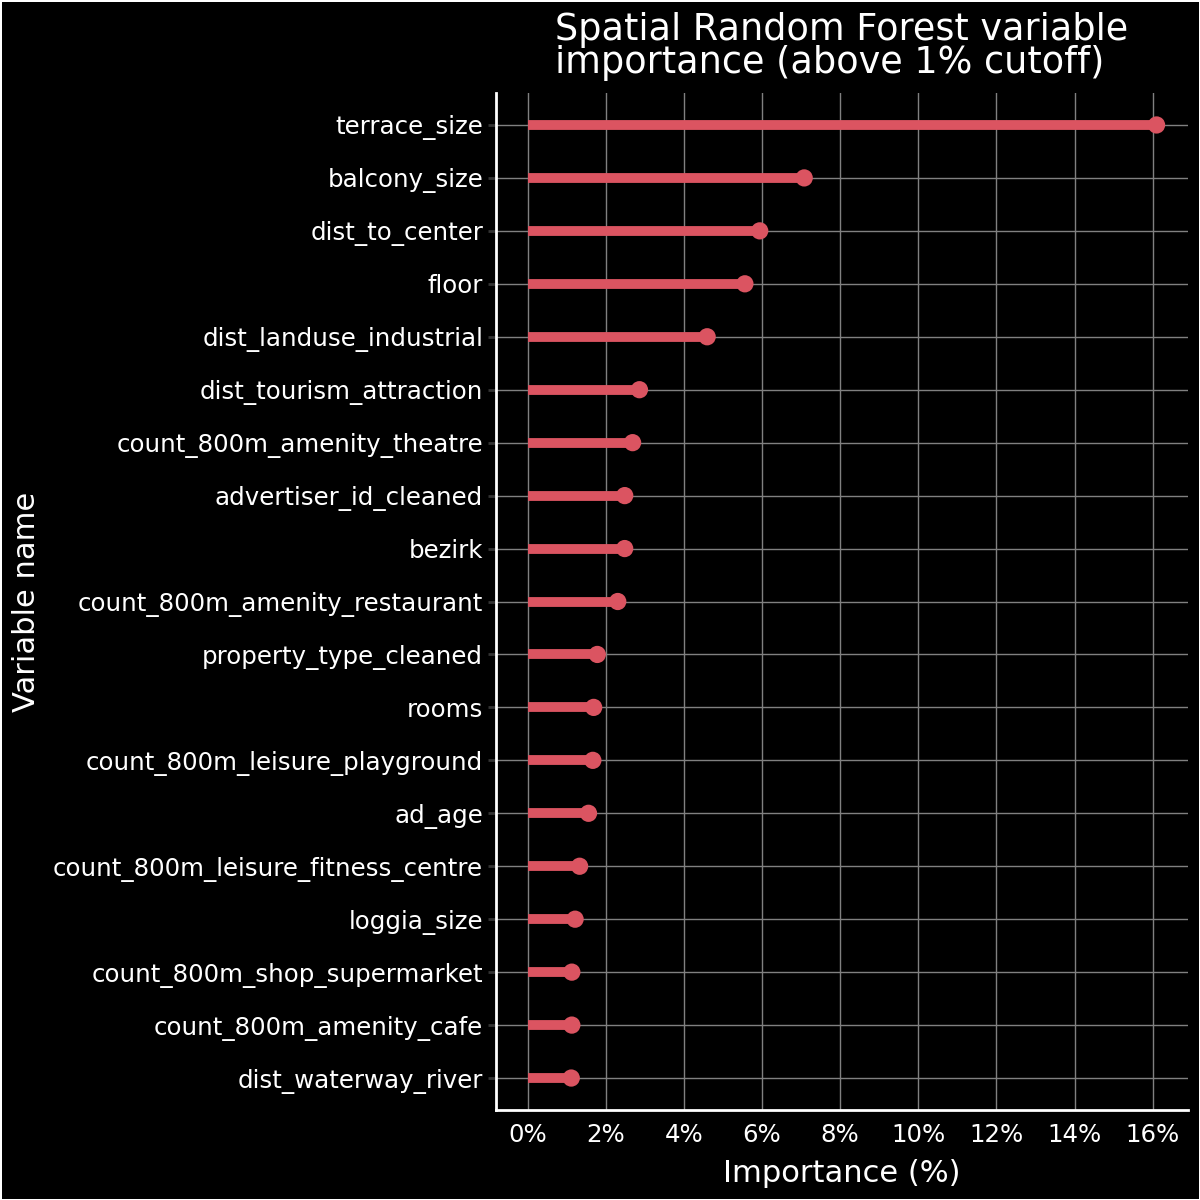

In [20]:
varimp_plot = (
    ggplot(
        grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (%)")
    + xlab("Variable name")
    + coord_flip()
    + ggtitle("Spatial Random Forest variable\nimportance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format(), breaks=np.arange(0, 0.21, 0.02))
    + theme_bw()
    + theme(figure_size=[6, 6],
            axis_text=element_text(color="white"),
            axis_title=element_text(color="white"),
            plot_title=element_text(color="white"),
            plot_background=element_rect(fill="black"),
            panel_background=element_rect(fill="black"),
            panel_grid_major=element_line(color="grey", size=0.5),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(color="white"),
            legend_position="none")
)
varimp_plot.save('varimp_plot.png', dpi=300)
display(varimp_plot)

From the SHAP-beeswarm plot, we can observe that e.g. the closer the property is to the center, the more expensive it tends to be - and naturally, this is the opposite for industrial sites.

In [21]:
prep_df = rf_cv.best_estimator_['preprocessor'].transform(gdf.drop(['geometry'], axis=1))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_cv.best_estimator_["preprocessor"].get_feature_names_out()
]

prep_df = pd.DataFrame(prep_df, columns=new_feature_names)

explainer = shap.TreeExplainer(rf_cv.best_estimator_['rf'])
shap_values = explainer(prep_df, approximate=True)

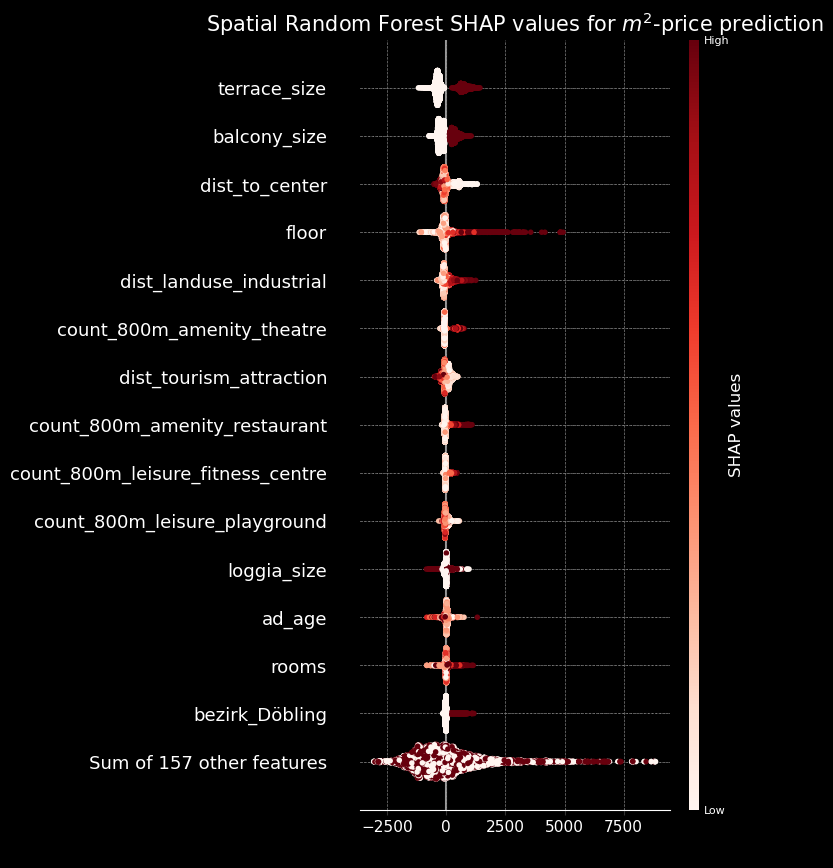

In [27]:
fig, ax = plt.subplots(figsize=(5,10))
shap.plots.beeswarm(shap_values, max_display=15, color=plt.get_cmap("Reds"), show=False, plot_size=None, ax=ax)

ax.set_title(r'Spatial Random Forest SHAP values for $m^{2}$-price prediction', color='w', fontsize=15)

fig.set_facecolor('k')
ax.set_facecolor('k')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color('w')

cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('SHAP values', color='white', fontsize=12)

ax.grid(color='grey', linestyle='--', linewidth=0.5)

ax.spines['top'].set_color('w')
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')

fig.savefig('shap_plot.png', dpi=300)

plt.show()

# Breakpoint 8: Run from here for real estate development identification prep

Now we can turn our attention towards identifying suitable areas for real estate development. For this, my approach is to randomly assign a location for each listing within Vienna's boundary, add spatial features for the new locations, and predict prices with my previously trained model. I repeat this three times to account for rare characteristics and to ensure that they do not distort the results. This way, I randomize the innate characteristics of the listings, thus the averages over a spatial unit will be independent of these innate features, and will only depend on spatial features.

In [35]:
def generate_points_in_polygon(polygon, num_points, seed):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    np.random.seed(seed)
    
    while len(points) < num_points:
        x_coords = np.random.uniform(min_x, max_x, num_points * 2)
        y_coords = np.random.uniform(min_y, max_y, num_points * 2)
        candidate_points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
        valid_points = [p for p in candidate_points if polygon.contains(p)]
        points.extend(valid_points[:num_points - len(points)])

    return points

First I create the random points and add the original, scraped features.

In [102]:
random_gdf_full = pd.DataFrame()
geom = vienna_boundary.geometry.values[0]
for i in range(1, 4):
    random_gdf = pd.DataFrame({'geometry' : generate_points_in_polygon(geom, len(gdf), seed = i)})
    for c in gdf.columns[0:16]:
        random_gdf[c] = gdf[c].values
    random_gdf_full = pd.concat([random_gdf_full, random_gdf], axis=0, ignore_index=True)

In [103]:
random_gdf_full = gpd.GeoDataFrame(random_gdf_full, geometry='geometry')
random_gdf_full.crs = crs_wgs

I enrich the data from OSM based on the new locations.

In [106]:
def osm_enrich(gdf):
    gdf = gdf.copy()
    gdf = gdf.to_crs(crs_at)
    for key, values in new_tags.items():
        for val in values:
            filtered_osm = osm_enrichment[key][osm_enrichment[key][key] == val].to_crs(crs_at)
            
            if not filtered_osm.empty:
                nearest = gdf.sjoin_nearest(filtered_osm[['geometry']], how='left', distance_col=f'dist_{key}_{val}')
                nearest = nearest.loc[~nearest.index.duplicated(keep='first')]
                gdf[f'dist_{key}_{val}'] = nearest[f'dist_{key}_{val}']

                if key not in ['landuse', 'waterway']:
                    for b in [100, 800]:
                        buffered = filtered_osm.copy()
                        buffered['geometry'] = buffered.buffer(b)
                        joined = gdf.sjoin(buffered, predicate='intersects')
                        gdf[f'count_{b}m_{key}_{val}'] = joined.groupby(joined.index).size()
            else:
                gdf[f'dist_{key}_{val}'] = float('nan')
                gdf[f'count_{key}_{val}'] = 0
    gdf = gdf.to_crs(crs_wgs)
    for c in [c for c in gdf.columns if c.startswith('count_')]:
        gdf[c] = gdf[c].fillna(0)
    return gdf

In [107]:
random_gdf_full = osm_enrich(random_gdf_full)

In [108]:
random_gdf_full.to_pickle('random_gdf_full_osm_enriched.pkl')

In [109]:
random_gdf_full = gpd.GeoDataFrame(pd.read_pickle('random_gdf_full_osm_enriched.pkl'), geometry='geometry')

In [110]:
random_gdf_full['latitude'] = random_gdf_full['geometry'].y
random_gdf_full['longitude'] = random_gdf_full['geometry'].x

I also add the features based on the raster data.

In [111]:
def raster_enrich(gdf, raster_files):
    
    gdf = gdf.copy()
    
    for key, value in raster_files.items():
        print(f'Processing {key}...')
        gdf[key] = calc_raster_total(gdf, value, 500)
    
    gdf['built_vol_2025'] = gdf['built_vol_2025'].astype(int)
    gdf['built_vol_2030'] = gdf['built_vol_2030'].astype(int)

    gdf['pop_2025'] = gdf['pop_2025'].apply(lambda x: x if x > 0 else 1)
    gdf['pop_2030'] = gdf['pop_2030'].apply(lambda x: x if x > 0 else 1)

    gdf['built_vol_2025'] = gdf['built_vol_2025'].apply(lambda x: x if x > 0 else 1)
    gdf['built_vol_2030'] = gdf['built_vol_2030'].apply(lambda x: x if x > 0 else 1)

    gdf['dist_to_center'] = gdf.apply(lambda x : ox.distance.great_circle(x.latitude, x.longitude, 48.2081, 16.3713), axis=1)

    gdf['pop_growth'] = gdf['pop_2030'] / gdf['pop_2025']
    gdf['built_vol_growth'] = gdf['built_vol_2030'] / gdf['built_vol_2025']

    return gdf

In [112]:
random_gdf_full = raster_enrich(random_gdf_full, raster_files_clipped)

Processing pop_2025...
Processing pop_2030...
Processing built_vol_2025...
Processing built_vol_2030...


In [113]:
random_gdf_full.to_pickle('random_gdf_raster_enriched.pkl')

# Breakpoint 9: Run from here for development opportunities identification

Now we can load the enriched, randomized dataset.

In [28]:
random_gdf_full = gpd.GeoDataFrame(pd.read_pickle('random_gdf_raster_enriched.pkl'), geometry='geometry')

I add the number of actual listings within a 500 meter radius of the random locations.

In [29]:
buffered = gdf.copy()
buffered = buffered.to_crs(crs_at)
buffered['geometry'] = buffered.buffer(500)
joined = random_gdf_full.to_crs(crs_at).sjoin(buffered, predicate='intersects')
random_gdf_full[f'count_{500}m_listings'] = joined.groupby(joined.index).size() # now there are no self-joins by design

In [30]:
random_gdf_full.count_500m_listings.fillna(0, inplace=True)

I add the neighbourhood.

In [31]:
result = gpd.sjoin(bezirk_boundary.to_crs(crs_at), random_gdf_full.to_crs(crs_at), how='inner', predicate='contains')
bezirk_mapping = result.groupby(result.index_right)['name'].first()
random_gdf_full['bezirk'] = random_gdf_full.index.map(bezirk_mapping)
random_gdf_full['bezirk'] = random_gdf_full['bezirk'].astype('category')

And cleaned variables from the original data.

In [32]:
random_gdf_full['advertiser_id_cleaned'] = list(gdf.advertiser_id_cleaned)*3
random_gdf_full['property_type_cleaned'] = list(gdf.property_type_cleaned)*3

Now we can make the predictions for the randomized data.

In [33]:
random_gdf_full['m2_price_pred'] = rf_cv.predict(random_gdf_full.drop(['geometry'], axis=1))

Let's plot the predicted prices! We can see some spatial patterns, but it is hard to see what would be the most suitable area for real estate development.

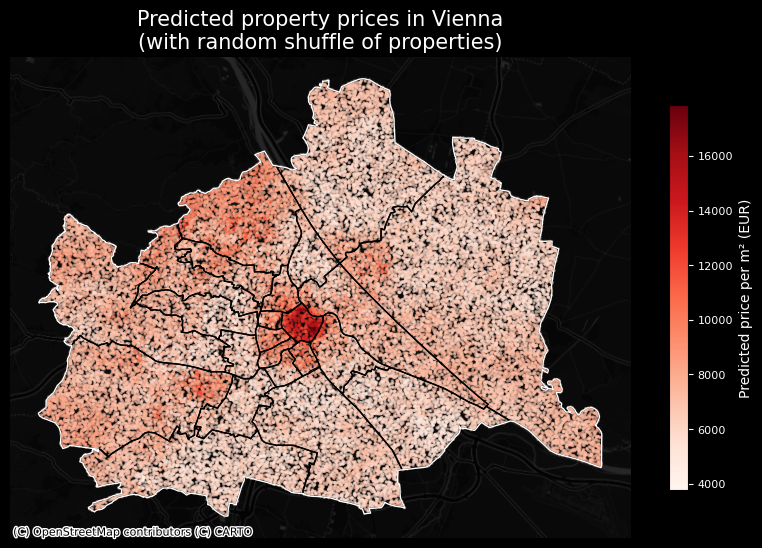

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
random_gdf_full.to_crs(crs_at).plot(ax=ax, column='m2_price_pred', cmap='Reds', markersize=2, alpha=0.5, legend=True, legend_kwds={'shrink': 0.5})
cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Predicted price per m² (EUR)', color='white', fontsize=10)
bezirk_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='k')
vienna_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='white')
ctx.add_basemap(ax,  
                crs = crs_at, 
                source = ctx.providers.CartoDB.DarkMatterNoLabels,)
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Predicted property prices in Vienna\n(with random shuffle of properties)', color='white', fontsize=15)

fig.savefig('random_predicted_prices.png', dpi=300)

plt.show()

In [35]:
random_gdf_full.m2_price_pred.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    44646.000000
mean      6854.310350
std       1257.212947
min       3765.558958
1%        4723.250752
5%        5242.643225
10%       5529.790425
25%       6046.640110
50%       6652.080763
75%       7448.091708
90%       8335.582831
95%       8974.985580
99%      11095.302489
max      17864.763540
Name: m2_price_pred, dtype: float64

To address this issue, I bin the data to hexagons.

In [36]:
def split_poly_to_hexagons(admin_gdf, resolution, crs):
    
    coords = list(admin_gdf.geometry.to_list()[0].exterior.coords)
    admin_geojson = {"type": "Polygon",  "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, 
                           resolution, 
                           geo_json_conformant=True)
    
    hexagon_geometries = {hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, \
                                geo_json=True)) for hex_id in hexagons}
    gdf_hexagon_geometries = gpd.GeoDataFrame(hexagon_geometries.items(), 
                                    columns=['hex_id', 'geometry'])
    gdf_hexagon_geometries.crs = crs
    
    return gdf_hexagon_geometries

In [81]:
hex_vienna = split_poly_to_hexagons(vienna_boundary, 8, crs_wgs)

I add the predicted mean price for each hexagon.

In [82]:
hex_vienna = hex_vienna.join(random_gdf_full.sjoin(hex_vienna, how='inner').groupby('hex_id').m2_price_pred.mean(), how='inner', on='hex_id')
hex_vienna.rename(columns={'m2_price_pred' : 'm2_price_pred_mean'}, inplace=True)

I also add the count of actual listings in each hexagon.

In [83]:
hex_vienna = hex_vienna.join(gdf.sjoin(hex_vienna, how='inner').groupby('hex_id').size().rename('count'), how='left', on='hex_id')
hex_vienna['count'].fillna(0, inplace=True)

I flag hexagons that overlap residential areas.

In [84]:
residential_hexes = hex_vienna.sjoin(osm_enrichment['landuse'][osm_enrichment['landuse']['landuse'] == 'residential'], how='inner', predicate='intersects')
hex_vienna['is_residential'] = hex_vienna.index.isin(residential_hexes.index)

Now we can define the most suitable areas: count of actual listings below the median (thus low competition), the mean price above the 85th percentile (thus high expected price), and overlaps a residential area (thus real estate development is legally possible).

In [85]:
hex_vienna['is_suitable'] = (hex_vienna.index.isin(
    hex_vienna[(hex_vienna['count'] < hex_vienna['count'].quantile(0.5))
               & (hex_vienna['m2_price_pred_mean'] > hex_vienna['m2_price_pred_mean'].quantile(0.85))
               & (hex_vienna['is_residential'] == True)].index).astype(int))
hex_vienna['centroid'] = hex_vienna.to_crs(crs_at).geometry.centroid

In [86]:
suitable_hex = hex_vienna[hex_vienna['is_suitable'] == 1].copy()
suitable_hex = suitable_hex.sort_values(by='m2_price_pred_mean', ascending=False)
suitable_hex['label'] = range(1, len(suitable_hex) + 1)
hex_vienna = hex_vienna.merge(suitable_hex[['label']], left_index=True, right_index=True, how='left')

Now we can plot the suitable areas, labeled by mean predicted price.

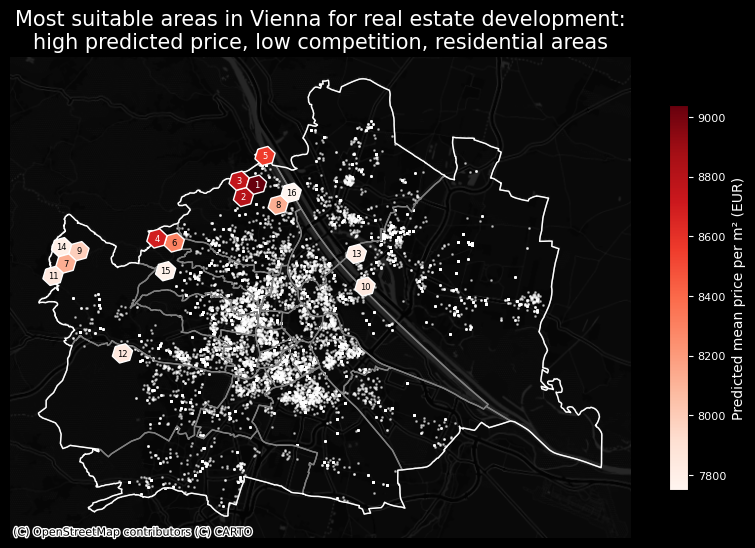

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.to_crs(crs_at).plot(ax=ax, color='white', markersize=1, alpha=0.5, legend=True)
bezirk_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='grey')
vienna_boundary.to_crs(crs_at).plot(ax=ax, color='none', edgecolor='white')

suitable_hex = hex_vienna[hex_vienna['is_suitable'] == 1].to_crs(crs_at)
suitable_hex.plot(ax=ax, column='m2_price_pred_mean', cmap='Reds', edgecolor='white', legend=True, legend_kwds={'shrink': 0.5})

for _, row in suitable_hex.iterrows():
    ax.text(row['centroid'].x, row['centroid'].y, str(int(row['label'])), 
            color='white' if row['m2_price_pred_mean'] > 8500 else 'k', fontsize=6, ha='center', va='center')

ctx.add_basemap(ax,  
                crs = crs_at, 
                source = ctx.providers.CartoDB.DarkMatterNoLabels,)

cbar = ax.get_figure().axes[-1]
cbar.tick_params(labelsize=8, colors='white')
cbar.set_ylabel('Predicted mean price per m² (EUR)', color='white', fontsize=10)
fig.set_facecolor('k')
ax.axis('off')
ax.set_title('Most suitable areas in Vienna for real estate development:\nhigh predicted price, low competition, residential areas', color='white', fontsize=15)

fig.savefig('suitable_areas.png', dpi=300)

plt.show()

We can even take a look at a more detailed map of the most suitable areas, visualizing current buildings and all roads. I do not distinguish between road types to avoid overcrowding the chart.

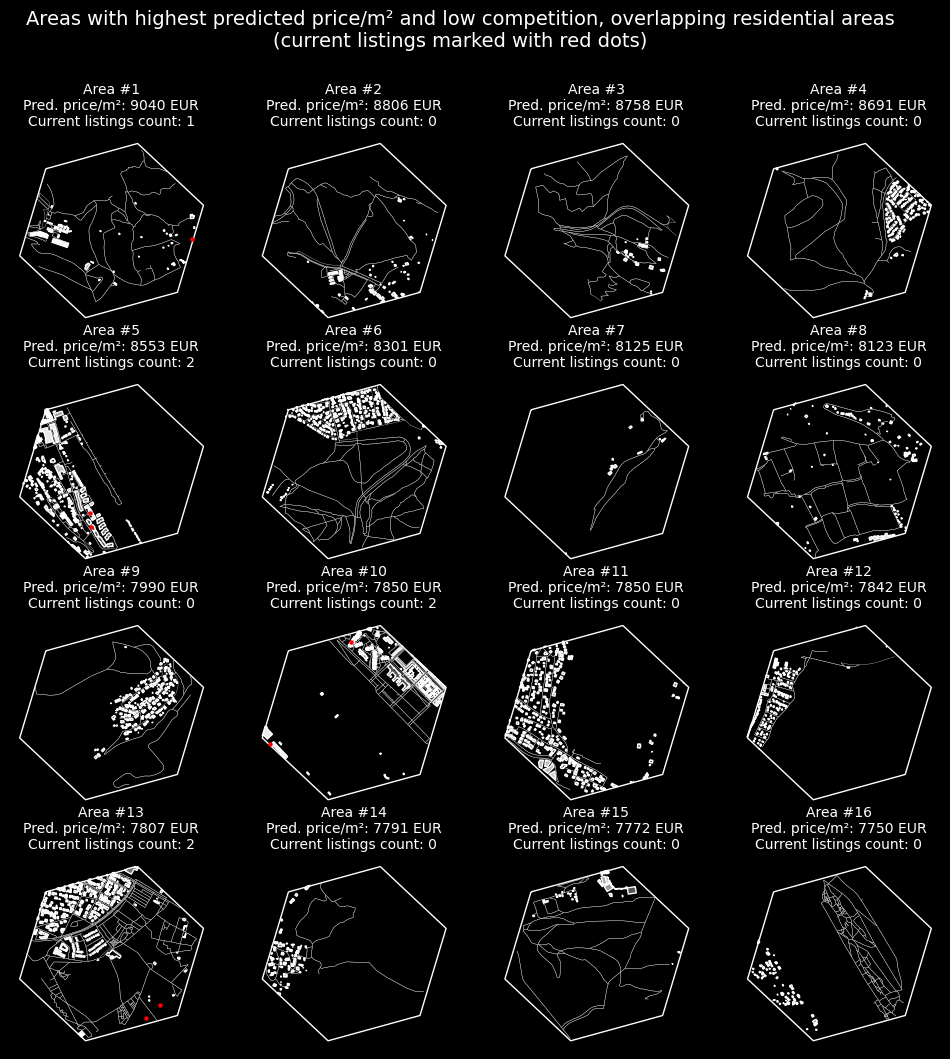

In [230]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
for i in range(0,16):
    hex_row = hex_vienna[hex_vienna['label'] == i+1].to_crs(crs_at)
    hex_row.plot(ax=axes[int(i // 4), int(i % 4)], color = 'k', edgecolor='white')
    axes[int(i // 4), int(i % 4)].set_axis_off()
    axes[int(i // 4), int(i % 4)].set_title(f'Area #{i+1}\nPred. price/m²: {hex_row['m2_price_pred_mean'].values[0]:.0f} EUR\nCurrent listings count: {hex_row['count'].values[0]:.0f}',
                                            color='white', fontsize=10)
    buildings = ox.features_from_polygon(hex_row.to_crs(crs_wgs).geometry.values[0], tags={'building' : True})
    G_drive = ox.graph_from_polygon(hex_row.to_crs(crs_wgs).geometry.values[0], network_type='all')
    nodes, edges = ox.graph_to_gdfs(G_drive)
    buildings = gpd.overlay(buildings.to_crs(crs_at), hex_row, how='intersection')
    buildings.to_crs(crs_at).plot(ax=axes[int(i // 4), int(i % 4)], cmap='Greys', edgecolor='white')
    edges = gpd.overlay(edges.to_crs(crs_at), hex_row, how='intersection')
    edges.to_crs(crs_at).plot(ax=axes[int(i // 4), int(i % 4)], color='lightgrey', linewidth=0.25)
    current_listings = gpd.overlay(gdf.to_crs(crs_at), hex_row, how='intersection')
    current_listings.to_crs(crs_at).plot(ax=axes[int(i // 4), int(i % 4)], color='red', markersize=5)
fig.set_facecolor('k')
fig.suptitle('Areas with highest predicted price/m² and low competition, overlapping residential areas\n(current listings marked with red dots)', color='white', fontsize=14)

fig.savefig('suitable_areas_detail.png', dpi=300)

plt.show()